### Compare louvain with subreddit communities
In this notebook, the goal is to compare the communities found with Louvain method and the community of each subreddit.

First, we build a list of communities by subreddit. A person is assigned to the subreddit's community where he post the most frequently.

In [339]:
import pandas as pd
from collections import Counter
import ast

# Load csv
df_subs = pd.read_csv('../data/csv/subs.csv')

# Keep with the most frequent subreddit for each person
df_subs["subreddit"] = df_subs["subreddit"].apply(lambda x: Counter(ast.literal_eval(x)).most_common(1)[0][0])

# Group by subreddit to build the list of communities
df_subs = df_subs.groupby("subreddit")["Id"].agg(lambda x: set(x))
com_subreddit = df_subs.values.tolist()

Then create another list of communities by running Louvain method on the graph "edges_deep_link_no_merge".

In [340]:
import networkx as nx
import networkx.algorithms.community as nx_comm

# Load graph
df_edges = pd.read_csv('../data/csv/edges_deep_link_no_merge.csv')
G = nx.from_pandas_edgelist(df_edges)

# Compute partitions with louvain
com_louvain = nx_comm.louvain_communities(G, seed=123)

We can print the number of Louvain communities and the number of subreddit.

In [341]:
print(f"Number of Louvain communities: {len(com_louvain)}")
print(f"Number of subreddit: {len(com_subreddit)}")

Number of Louvain communities: 260
Number of subreddit: 10


Louvain method extract a lot of communities compare to the number of subreddit. A subreddit can therefore have several inner communities.

The two lists of communities are not extracted from the same file. So there may be a difference between the people in the two datasets. We can therefore compare them:

In [342]:
persons_louvain = set().union(*com_louvain)
persons_subreddit = set().union(*com_subreddit)

print(f"Total number of person in list of communities:\n • Louvain - {len(persons_louvain)}\n • Subreddit - {len(persons_subreddit)}")
print(f"Intersection between the two set of people: {len(persons_louvain.intersection(persons_subreddit))}")

Total number of person in list of communities:
 • Louvain - 25723
 • Subreddit - 27093
Intersection between the two set of people: 25723


As we said before, a subreddit can have several communities but it can be interesting to see if communities are formed by people from different subreddits. For this, we loop over the Louvain communities and compute the percentage of people coming from each subreddit. It gives a matrix where rows are Louvain communities and columns are the percentage of people from each subreddit.

As all the people in the Louvain dataset are included in the subreddit dataset, the sum of element in each line is a percentage of 1.0.

In [355]:
# Get set intersection between louvain and subreddit communities
intersections = []
for cl in com_louvain:
   intersections.append([len(cl.intersection(cs)) / len(cl) for cs in com_subreddit])

# Print matrix
for inter in intersections[0:4]:
   print(['%.2f' % v for v in inter])
print("...")

for inter in intersections[-4:]:
   print(['%.2f' % v for v in inter])

['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '1.00', '0.00', '0.00']
['0.01', '0.02', '0.04', '0.87', '0.00', '0.01', '0.01', '0.00', '0.02', '0.01']
['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '1.00']
['0.00', '0.24', '0.71', '0.01', '0.00', '0.02', '0.01', '0.00', '0.01', '0.00']
...
['0.05', '0.81', '0.02', '0.00', '0.04', '0.02', '0.04', '0.02', '0.00', '0.00']
['0.00', '0.00', '0.00', '1.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
['0.00', '1.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
['0.00', '1.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']


To have a better understanding of the result, we can plot a histogram of the number of different subreddits that people in a Louvain community belong to.

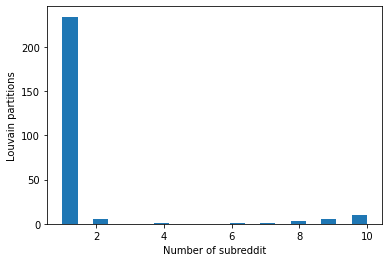

In [344]:
from matplotlib import pyplot as plt

# Compute repartition for each Louvain community
repartition = [sum(1 if v else 0 for v in inter) for inter in intersections]

# Plot
plt.hist(repartition, bins=20)
plt.ylabel("Louvain partitions")
plt.xlabel("Number of subreddit")
plt.savefig('../data/images/inner_communities_repartition.pdf')
plt.show()

We can see that the Louvain communities are not all restricted to one subreddit. Some are interacting in several subreddit but this is not the case for the majority.

### Summary

Louvain method is a technique that find communities from large networks. In our case, we can see that there is 260 communities found with Louvain method in only 10 subreddit. Thus each subreddit has inner communities that interact with each other but all these communities are not restricted to one subreddit. Some are interacting in several subreddit.